# Analysis of training time vs. dimensionality of target distribution

In [306]:
import os
import sys
import pickle
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import OrderedDict

from utils.data_utils import calc_avg_vals_errors, block_resampling

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%autoreload 2

In [218]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
markers = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
linestyles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
plt.style.use('/Users/saforem2/.config/matplotlib/'
               + 'stylelib/ggplot_sam.mplstyle')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.pad'] = 3.5
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.pad'] = 3.4
plt.rcParams['xtick.minor.size'] = 2.0
plt.rcParams['xtick.minor.width'] = 0.6

%matplotlib notebook

In [219]:
def load_train_times(log_dir):
    info_dir = os.path.join(log_dir, 'run_info')
    train_times_file = os.path.join(info_dir, 'train_time.pkl')
    if os.path.isfile(train_times_file):
        with open(train_times_file, 'rb') as f:
            train_times_dict = pickle.load(f)
        return train_times_dict
    else:
        print(f"Unable to locate {train_times_file}, file does not exist.")

In [220]:
def split_dict(d):
    keys_arr = np.array(list(d.keys()))
    vals_arr = np.array(list(d.values()))
    return keys_arr, vals_arr

In [249]:
def average_duplicates(arr):
    _dict = {}
    for row in arr:
        key = int(row[0])
        avg = row[1]
        err = row[2]
        if key not in list(_dict.keys()):
            _dict[key] = [avg, err]
        else:  # dictionary already had a value assigned to this key
            avg1, err1 = _dict[key]
            new_avg = np.mean([avg, avg1])
            new_err = np.mean([err, err1])
            _dict[key] = [new_avg, new_err]
    new_arr = []
    for key, val in _dict.items():
        new_arr.append([int(key), *val])
    return np.array(new_arr)

## Load training time data from log dirs

In [356]:
log_dir = '../../timing_logs/'
log_dirs = [os.path.join(log_dir, i) 
            for i in os.listdir(log_dir) 
            if os.path.isdir(os.path.join(log_dir, i))]

In [357]:
tt_dict = {}
for d in log_dirs:
    name = d.split('/')[-1]
    name = name.split('_')
    name = f'tt_dim{name[2]}_{name[3]}'  # tt = train_times
    tt_dict[name] = load_train_times(d)

In [358]:
tt_diffs_dict = {}
tt_per_step_dict = {}
for key, val in tt_dict.items():
    tt_diffs_dict[key] = {}
    steps = np.array(list(val.keys()))
    dsteps = np.array(list(val.keys())[1:])
    times = np.array(list(val.values()))
    step_diffs = steps[1:] - steps[:-1]
    time_diffs = times[1:] - times[:-1]
    time_diffs_per_step = time_diffs / step_diffs
    tt_diffs_dict[key] = dict(zip(dsteps, diffs))
    tt_per_step_dict[key] = time_diffs_per_step
    
def split_dim(d):
    return d[0].split('_')[-1].lstrip('dim')

tt_diffs_dict = OrderedDict(sorted(tt_diffs_dict.items(), 
                                   key=lambda d: int(split_dim(d))))
tt_per_step_dict = OrderedDict(sorted(tt_per_step_dict.items(),
                                      key=lambda d: int(split_dim(d))))

In [359]:
#_dict = {}
#num_blocks = np.arange(0, 500, 100)
#num_blocks[0] = 2
#for nb in num_blocks:
tt_per_step_arr = []
for key, val in tt_per_step_dict.items():
    dimension = int(key.split('_')[1].lstrip('dim'))
    avg, err = calc_avg_vals_errors(val, num_blocks=int(len(val)**(1./2.5)))
    #except ValueError:
    #    import pdb
    #    pdb.set_trace()
    #avg_time_per_step = np.mean(val)
    #std_time_per_step = np.std(val)
    tt_per_step_arr.append([dimension, avg, err])
tt_per_step_arr = average_duplicates(np.array(tt_per_step_arr))
#_dict[nb] = tt_per_step_arr

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Average training time / step (s)')

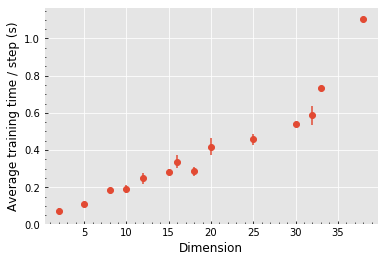

In [360]:
fig, ax = plt.subplots()
i = 0
#for key, val in _dict.items():
ax.errorbar(tt_per_step_arr[:, 0], tt_per_step_arr[:, 1], 
            yerr=tt_per_step_arr[:, 2],
            color='C0', marker='o', ls='')#, fillstyle='')
#ax.legend(loc='best')
ax.set_xlabel('Dimension')
ax.set_ylabel('Average training time / step (s)')
plt.show()

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Average training time / step (s)')

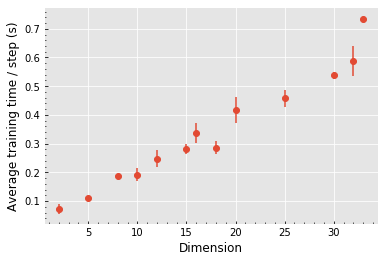

In [355]:
fig, ax = plt.subplots()
i = 0
#for key, val in _dict.items():
ax.errorbar(tt_per_step_arr[:, 0], tt_per_step_arr[:, 1], 
            yerr=tt_per_step_arr[:, 2],
            color='C0', marker='o', ls='')#, fillstyle='')
#ax.legend(loc='best')
ax.set_xlabel('Dimension')
ax.set_ylabel('Average training time / step (s)')
plt.show()

In [ ]:
fig, ax = plt.subplots()
i = 0
for key, val in tt_diffs_dict.items():
    leg_label = 'dimension ' + key.split('_')[-1].lstrip('dim')
    
    ax.plot(steps_arr[::5], t_diffs_arr[::5], 
            color=colors[i], marker=markers[i],
            ls=linestyles[i], label=leg_label)
    i += 1
ax.set_xlabel('Training step')
ax.set_ylabel('Cumulative training time')
ax.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


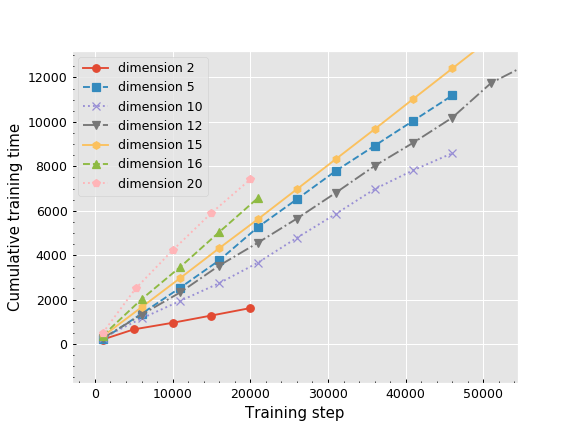

Text(0.5, 0, 'Training step')

Text(0, 0.5, 'Cumulative training time')

In [97]:
fig, ax = plt.subplots()
i = 0
for key, val in tt_diffs_dict.items():
    leg_label = 'dimension ' + key.split('_')[-1].lstrip('dim')
    steps_arr, t_diffs_arr = split_dict(val)
    ax.plot(steps_arr[::5], t_diffs_arr[::5], 
            color=colors[i], marker=markers[i],
            ls=linestyles[i], label=leg_label)
    i += 1
ax.set_xlabel('Training step')
ax.set_ylabel('Cumulative training time')
ax.legend(loc='best')
plt.show()

In [98]:
steps_dict = {}
for key, val in tt_diffs_dict.items():
    #leg_label = 'dimension ' + key.split('_')[-1].lstrip('dim')
    #steps_arr, t_diffs_arr = split_dict(val)
    steps_dict[key], _ = split_dict(val)

In [99]:
steps_dict

{'tt_dim2': array([ 1000,  1561,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000]),
 'tt_dim5': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
        19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000,
        28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000,
        37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000,
        46000, 47000, 48000]),
 'tt_dim10': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
        19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000,
        28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000,
        37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000,
        46000, 47000, 48000, 49000, 50000]),
